<a href="https://colab.research.google.com/github/EmilianoLS/DiTellaML/blob/main/Deep%20Learning/Pr%C3%A1ctica_3_Estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 0. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en el práctico 0). 

Para eso, comenzamos por cargar y visualizar el dataset:

In [18]:
import torchvision
import torchvision.datasets as datasets
      
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib
# from six.moves import urllib   

# Tuve que agregar esta parte porque parece que hubo un cambio en el hosting del dataset MNIST y no
# permitia descargarlo. Con el agregado de abajo se soluciona y funciona normalmente 


opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


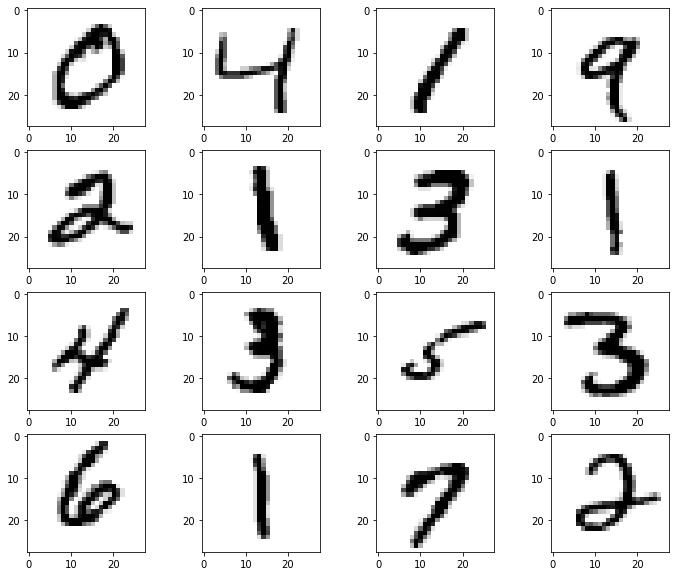

In [19]:

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))
    

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 10 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))         # linear output
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

Epoch 0, loss = 0.746911
Epoch 1, loss = 0.736176
Epoch 2, loss = 0.414031
Epoch 3, loss = 0.255527
Epoch 4, loss = 0.374821


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

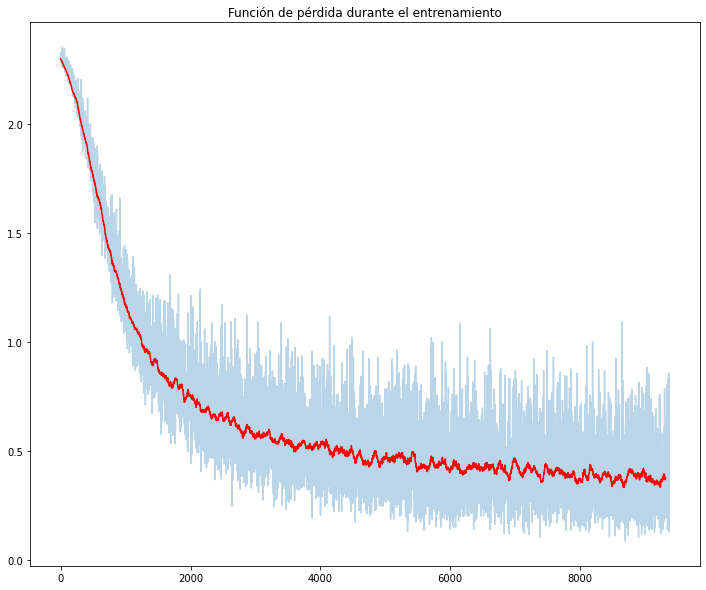

In [21]:
# Definimos el modelo del perceptrón
input_features = 28*28
hidden_neurons = 15
num_outputs = 10

# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        x = x.view(x.size(0), -1) # Agregado para "aplanar" la entrada y que la red pueda leer los inputs
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardamos el modelo para poder reutilizarlo

In [22]:
torch.save(net.state_dict(), "./mlp20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [23]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

{'0': {'precision': 0.917228103946102, 'recall': 0.9724489795918367, 'f1-score': 0.9440316988608223, 'support': 980}, '1': {'precision': 0.9576124567474048, 'recall': 0.9753303964757709, 'f1-score': 0.9663902226102139, 'support': 1135}, '2': {'precision': 0.9016227180527383, 'recall': 0.8614341085271318, 'f1-score': 0.8810703666997026, 'support': 1032}, '3': {'precision': 0.8738916256157635, 'recall': 0.8782178217821782, 'f1-score': 0.8760493827160493, 'support': 1010}, '4': {'precision': 0.8878787878787879, 'recall': 0.895112016293279, 'f1-score': 0.8914807302231237, 'support': 982}, '5': {'precision': 0.8633093525179856, 'recall': 0.8071748878923767, 'f1-score': 0.8342989571263035, 'support': 892}, '6': {'precision': 0.9235537190082644, 'recall': 0.9331941544885177, 'f1-score': 0.9283489096573209, 'support': 958}, '7': {'precision': 0.919, 'recall': 0.8939688715953308, 'f1-score': 0.9063116370808679, 'support': 1028}, '8': {'precision': 0.8452868852459017, 'recall': 0.847022587268993

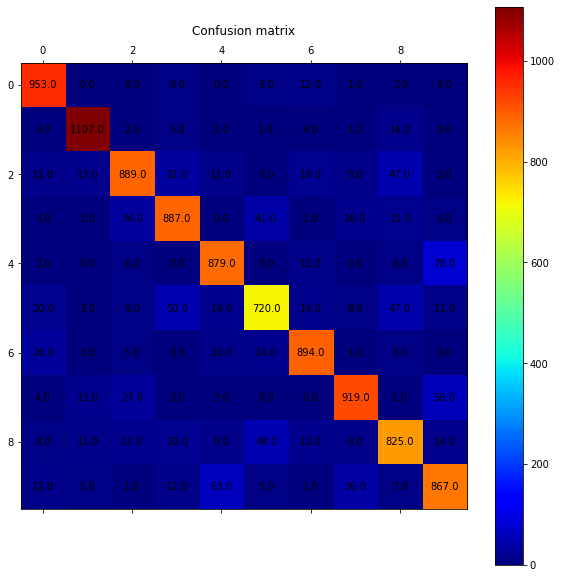

In [24]:
def showTestResults(model, flag):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test 
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  if flag:
    x_test = x_test.view(x_test.size(0), -1) # Agregado para "aplanar" la entrada y que la red pueda leer los inputs

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificación (accuracy, etc)
  report = classification_report(y_test, pred_y, output_dict = True)

  # Computo la matriz de confusión y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
      
  plt.title("Confusion matrix")
  plt.colorbar()

  return report

report_mlp = showTestResults(net, flag = True)
print(report_mlp)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [25]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        # Selección de los valores de los parámetros:
        # El elemento Conv2d toma como input 3 valores:
          # Input channels
          # El número de features maps a la salida
          # Tamaño del kernel
        
        # Primera capa convolucional:

        # El input channel, al tratarse de un dataset en B&W, es de 1.
        # El número de features maps está dado, por lo que es de 6
        # El tamaño del kernel no está dado, pero se seleccionó un tamaño de 5 (en otros ejemplos se utiliza este número
        # pero más adelante se explica el por qué se utilizó este valor)

        # Con esta configuración, la salida de la primera convolución tendrá 6 feature maps, cada una de tamaño:
        # (28 - 5 + 0)/1 + 1 = 24 x 24

        self.conv1 = nn.Conv2d(1, 6, 5)     

        # Primera capa de Max Pooling:

        # La siguiente capa es la de MaxPooling, lo que implica que habrá una reducción de dimensionalidad,
        # más específicamente, la imagen pasara de un tamaño de 24 * 24 a una de 24/2 = 12 * 12
        # En conclusión, la salida de esta capa será de 6*12*12  

        # Segunda capa convolucional:

        # Hasta el momento, por la red están fluyendo 6 map features de tamaño 12x12,
        # por lo tanto, hay que determinar el valor de los parámetros que ingresan a la segunda capa convolucional.
        # Al fluir 6 feature maps, el valor del channel para esta segunda capa es de 6
        # El número de features maps está dado, por lo que es de 16
        # El tamaño del kernel se mantiene igual.

        # Con esta configuración, la salida de la segunda convolución tendrá 16 feature maps, cada una de tamaño:
        # (12 - 5 + 0)/1 + 1 = 8 x 8

        self.conv2 = nn.Conv2d(6, 16, 5)

        # Segunda capa de Max Pooling:

        # La siguiente capa es la de MaxPooling, lo que implica que habrá una reducción de dimensionalidad,
        # más específicamente, la imagen pasara de un tamaño de 8 * 8 a una de 8/2 = 4 * 4
        # En conclusión, la salida de esta capa será de 16*4*4

        # Por este motivo, ese es el valor que se coloca como input en la red fully connected.  

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0, loss = 0.261433
Epoch 1, loss = 0.107346
Epoch 2, loss = 0.192
Epoch 3, loss = 0.0776301
Epoch 4, loss = 0.161234


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

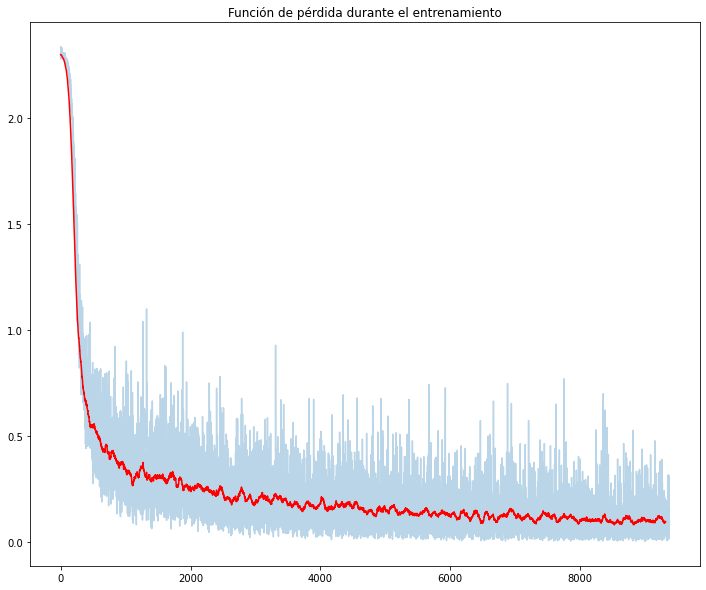

In [26]:
# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss() 

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        #x = x.view(x.size(0), -1)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardo el modelo

In [27]:
torch.save(net.state_dict(), "./cnn20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [28]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

{'0': {'precision': 0.9776876267748479, 'recall': 0.9836734693877551, 'f1-score': 0.9806714140386572, 'support': 980}, '1': {'precision': 0.9868073878627969, 'recall': 0.9885462555066079, 'f1-score': 0.9876760563380281, 'support': 1135}, '2': {'precision': 0.983, 'recall': 0.9525193798449613, 'f1-score': 0.9675196850393701, 'support': 1032}, '3': {'precision': 0.9273743016759777, 'recall': 0.9861386138613861, 'f1-score': 0.9558541266794626, 'support': 1010}, '4': {'precision': 0.9854620976116303, 'recall': 0.9663951120162932, 'f1-score': 0.9758354755784062, 'support': 982}, '5': {'precision': 0.9675977653631285, 'recall': 0.9708520179372198, 'f1-score': 0.9692221600447677, 'support': 892}, '6': {'precision': 0.9883103081827843, 'recall': 0.9707724425887265, 'f1-score': 0.9794628751974724, 'support': 958}, '7': {'precision': 0.9754420432220039, 'recall': 0.9659533073929961, 'f1-score': 0.970674486803519, 'support': 1028}, '8': {'precision': 0.9697286012526096, 'recall': 0.95379876796714

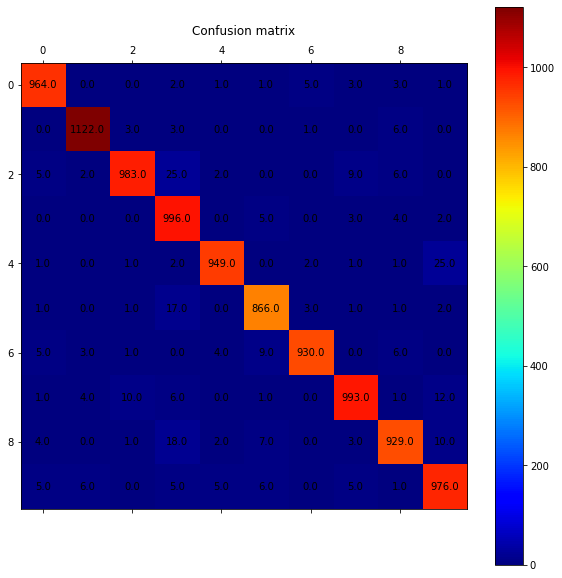

In [29]:
# Mostramos los resultados
report_cnn = showTestResults(net, flag = False)
print(report_cnn)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida par el perceptrón muticapa y la red neuronal convolucional. 

### Comparación de modelos

In [35]:
# Transformo ambos classification reports en dataframes para poder manipular
# los valores y graficarlos

# MLP
results_mlp = pd.DataFrame(report_mlp).transpose()

# CNN 
results_cnn = pd.DataFrame(report_cnn).transpose()

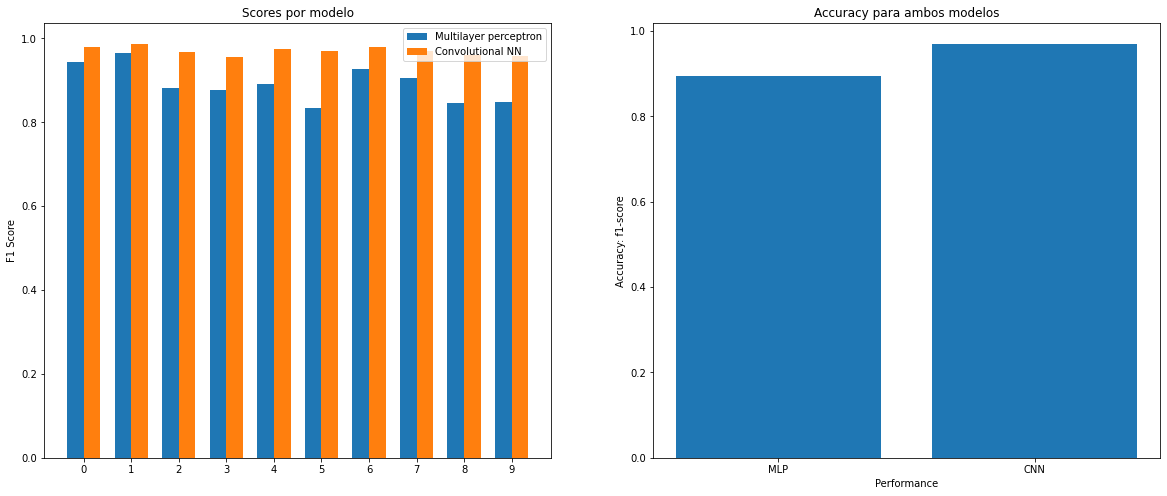

In [58]:
# Comparo 'f1-scores' de ambos modelos
# Seleccioné el f1 score ya que es una media armonica entre el accuracy y el recall 
# por lo que el valor que tome este indicador da una buena idea de lo bien que performa 
# el modelo (a diferencia del accuracy o el recall solos, que pueden llevar a conclusiones
# erróneas si no se tienen en cuenta el balance de las clases, etc.) en este sentido, 
# es similar a un AUC en cuanto a capacidad para determinar la performance de un modelo


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

##################################################################################
# Ploteo los f1 score de ambos modelos

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mlp_f1_score = results_mlp['f1-score'][:10].values
cnn_f1_score = results_cnn['f1-score'][:10].values


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


rects1 = ax[0].bar(x - width/2, mlp_f1_score, width, label='Multilayer perceptron')
rects2 = ax[0].bar(x + width/2, cnn_f1_score, width, label='Convolutional NN')

ax[0].set_ylabel('F1 Score')
ax[0].set_title('Scores por modelo')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

##################################################################################
# Ploteo el accuracy final de ambos modelos

model = ('MLP', 'CNN')
x_pos = np.arange(len(model))
accuracy_mlp = results_mlp['f1-score'][10]
accuracy_cnn = results_cnn['f1-score'][10]
accuracy = [accuracy_mlp, accuracy_cnn]


ax[1].bar(x_pos, accuracy, align='center')
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(model)
ax[1].set_xlabel('Performance')
ax[1].set_title('Accuracy para ambos modelos')
ax[1].set_ylabel('Accuracy: f1-score')
##################################################################################

plt.show()

Puede observarse que ambos modelos performan muy bien (ambos tienen un *f1-score* superior a 0.8 en todas las clases, es decir en la clasificación de todos los números). Sin embargo, queda en evidencia que la red neuronal convolucional es significativamente mejor que un *perceptrón multicapa*, especialmente para aquellas clases (números) donde el percetrón tenía mayor dificultad para clasificar (en la *matriz de confusión* se ve que el modelo confundía los números 3,5 y 8 especialmente).

En el segundo gráfico demuestra de forma más resumida los resultados de ambos modelos, llegando a la misma conclusión: **la red neuronal convolucional supera al perceptrón**.

Con esta comparación queda demostrado que en lo que a análisis de imágenes respecta, las redes neuronales convolucionales son significativamente mejores que los perceptrones.